In [1]:
import numpy as np
import pandas as pd
from interactions_data import ExplicitDataset
from interactions_model import EmbeddingNet, find_lr, fit_model
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim
import CLR as CLR
import OneCycle as OneCycle

In [2]:
print(torch.cuda.is_available())

True


In [3]:
path = 'data/movielens-small/'
train = ExplicitDataset(csv_file=path+'train.csv', users='userId', items='movieId')
test = ExplicitDataset(csv_file=path+'test.csv', users='userId', items='movieId')

In [4]:
print("Training samples: ", 
      len(train),
      "\nTesting samples: ",
      len(test))

Training samples:  90752 
Testing samples:  10084


In [5]:
train.df.head()

,userId,movieId,rating
0,463,2247,2.5
1,306,1616,2.5
2,605,98,3.5
3,306,2437,3.0
4,408,2030,4.0


In [6]:
test.df.head()

,userId,movieId,rating
0,160,6208,0.5
1,134,857,4.0
2,522,8627,5.0
3,367,1118,3.0
4,57,200,4.0


In [7]:
print("Users in train set:", train.df.userId.nunique())
print("Min:", min(train.df.userId.unique()), 
      "Max:", max(train.df.userId.unique()), "\n")
print("Users in test set:", test.df.userId.nunique())
print("Min:", min(test.df.userId.unique()), 
      "Max:", max(test.df.userId.unique()))

Users in train set: 610
Min: 0 Max: 609 

Users in test set: 610
Min: 0 Max: 609


In [8]:
print("Items in train set:", train.df.movieId.nunique())
print("Min:", min(train.df.movieId.unique()), 
      "Max:", max(train.df.movieId.unique()), "\n")
print("Items in test set:", test.df.movieId.nunique())
print("Min:", min(test.df.movieId.unique()), 
      "Max:", max(test.df.movieId.unique()))

Items in train set: 9357
Min: 0 Max: 9722 

Items in test set: 3679
Min: 0 Max: 9723


In [9]:
n_users = max(max(train.df.userId.unique()), max(test.df.userId.unique()))
n_items = max(max(train.df.movieId.unique()), max(test.df.movieId.unique()))
max_score = max(train.df.rating)
min_score = min(train.df.rating)
epoch = 10
bs = 128

In [10]:
train_loader = DataLoader(dataset=train,
                          batch_size=bs,
                          shuffle=False)

test_loader = DataLoader(dataset=test,
                         batch_size=bs,
                         shuffle=False)

In [11]:
# create the model
model = EmbeddingNet(10, n_users, n_items, min_score, max_score).cuda()

# show its parameters
model

EmbeddingNet(
  (u): Embedding(609, 10)
  (i): Embedding(9723, 10)
  (lin1): Linear(in_features=20, out_features=10, bias=True)
  (lin2): Linear(in_features=10, out_features=1, bias=True)
  (drop1): Dropout(p=0.05)
  (drop2): Dropout(p=0.15)
)

## Learning rate finder

In [12]:
# define the optimizer and loss criterion
# optimizer = optim.SGD(model.parameters(), lr=1e-4, momentum=0.95, weight_decay=1e-4)
optimizer = optim.Adam(model.parameters())
criterion=nn.MSELoss()

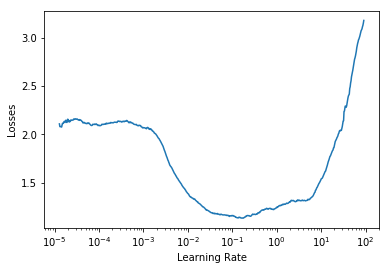

In [13]:
find_lr(model, train_loader, optimizer, criterion)

In [14]:
# create new model with re-initialized weights
model = EmbeddingNet(10, n_users, n_items, min_score, max_score).cuda()

In [15]:
# set the learning rate
lr = 1e-2

## Cyclic Learning Rates

In [16]:
onecycle = OneCycle.OneCycle(nb=int(len(train_loader)*epoch/bs), 
                             max_lr=1e-2,
                             momentum_vals=(0.95, 0.8))

## Training

In [17]:
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.95, weight_decay=1e-4)
# optimizer = optim.Adam(model.parameters(), lr=lr)
criterion=nn.MSELoss()

In [18]:
fit_model(epochs=2, 
          model=model, 
          optimizer=optimizer,
          criterion=criterion,
          train=train_loader, 
          test=test_loader)


Training Loss: 1.092.. 
Test Loss: 1.076..  Epoch: 1/2.. 



Training Loss: 1.090.. 
Test Loss: 1.076..  Epoch: 2/2.. 


In [17]:
model.eval()

dataiter = iter(test_loader)

In [18]:
users, items, ratings = dataiter.next()

In [19]:
ratings

tensor([0.5000, 4.0000, 5.0000, 3.0000, 4.0000, 4.0000, 2.0000, 4.0000, 2.0000,
        4.0000, 3.0000, 4.0000, 5.0000, 5.0000, 5.0000, 2.0000, 1.5000, 3.5000,
        2.5000, 2.0000, 3.0000, 5.0000, 4.0000, 4.0000, 4.0000, 4.0000, 2.5000,
        4.0000, 0.5000, 4.0000, 3.5000, 4.0000, 4.5000, 5.0000, 3.5000, 3.0000,
        3.0000, 4.0000, 2.0000, 3.0000, 3.0000, 5.0000, 4.0000, 3.5000, 0.5000,
        3.5000, 3.0000, 1.5000, 3.5000, 5.0000, 5.0000, 4.0000, 5.0000, 3.5000,
        4.0000, 4.0000, 3.0000, 3.0000, 2.0000, 2.5000, 4.0000, 5.0000, 4.0000,
        4.5000, 5.0000, 5.0000, 5.0000, 4.0000, 3.0000, 3.5000, 4.0000, 5.0000,
        4.0000, 1.5000, 5.0000, 3.5000, 2.0000, 3.0000, 2.0000, 4.0000, 4.5000,
        3.5000, 3.5000, 4.0000, 2.5000, 4.0000, 3.5000, 2.5000, 3.0000, 1.0000,
        4.0000, 4.0000, 4.0000, 2.0000, 3.0000, 4.0000, 3.5000, 4.0000, 5.0000,
        4.0000, 3.5000, 4.0000, 3.5000, 5.0000, 4.0000, 4.0000, 2.0000, 3.5000,
        2.0000, 4.0000, 2.0000, 0.5000, 

In [20]:
with torch.no_grad():
    output = model(users, items).view(bs).cpu().numpy()

ratings = ratings.cpu().numpy()

In [21]:
output

array([2.6532478, 2.6405017, 2.6621253, 2.669378 , 2.6575744, 2.662486 ,
       2.65668  , 1.6789727, 2.663658 , 2.6374884, 2.6408446, 2.6415048,
       2.6472414, 2.632039 , 2.6612802, 2.6268284, 2.6503525, 2.6651611,
       2.6650126, 2.671319 , 2.6599352, 2.6690073, 2.6706314, 2.6888833,
       2.6732924, 2.660433 , 2.6448584, 2.6653266, 2.64071  , 2.6815152,
       2.6552804, 2.6636183, 2.6439917, 2.6569061, 2.646194 , 2.6564147,
       2.6754594, 2.6748924, 2.668139 , 2.6626742, 2.650858 , 2.6432626,
       2.63706  , 2.6374607, 2.6449142, 2.640527 , 2.6545246, 2.6660438,
       2.690929 , 2.6554976, 2.6466553, 2.6608496, 2.6480286, 2.633802 ,
       2.648716 , 2.631733 , 2.655828 , 2.6767685, 2.6675482, 2.671418 ,
       2.6546588, 2.6746047, 2.6505797, 2.6468892, 2.647667 , 2.627858 ,
       2.6672113, 2.6508546, 2.6743362, 2.6441815, 2.6680868, 2.6785343,
       2.6630764, 2.6419277, 2.6363144, 2.628058 , 2.6566265, 2.679122 ,
       2.6702006, 2.6801422, 2.6549368, 2.6474047, 

In [22]:
mse = np.mean((ratings - output)**2)

In [23]:
mse

1.9374061